
# Question 2: Age Groups of Business Owners Across 4 years
-   What ages are most business owners and how has the average age of business owners changed over time? Increase? Decrease? Drastic changes?


--------------------

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import random
import requests
from IPython.display import display

pd.options.display.max_columns = None
pd.options.display.max_rows = None




### Extraction:
-   URLS for different years to acquire the number of business owners that belong to each age group for api call

In [2]:

url2018 = "https://api.census.gov/data/2018/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP&for=us:*&QDESC_LABEL=OWNRAGE"
url2019 = "https://api.census.gov/data/2019/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP&for=us:*&QDESC_LABEL=OWNRAGE"
url2020 = "https://api.census.gov/data/2020/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP&for=us:*&QDESC_LABEL=OWNRAGE"
url2017 = "https://api.census.gov/data/2017/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP&for=us:*&QDESC_LABEL=OWNRAGE"

key ="&key=7325759f1ae7120e7f55c22ccd6fe9de386a7a0c"


-   Function that returns the data frame of the url's api call


In [3]:

#returns a dataframe after you pass in a string url that's valid hopefully
def getDF(apiurl):
    response = requests.get(apiurl)

    col = response.json()[0] # header row

    test = pd.DataFrame(data = response.json(),columns = col) #makes data frame with the header row as column names
    test.drop(0,axis = 0,inplace=True) #it came with the header row that I dropped
    return test


-   Calls API to get the dataframe for each year and adds to a dictionary with key as year and value as the dataframe to access each through a loop


In [4]:
#makes a dictionary of urls for looping
myurldict = {2017:url2017, 2018:url2018, 2019:url2019, 2020:url2020}
dfs = {} #stores the 4 dataframes in here matching the year
for keys in myurldict:
    #make the api with the key
    apiurl = myurldict[keys] + key
    #get the dataframe for this api call
    df=getDF(apiurl)
    #add this dataframe to our dictionary with the year as its key
    dfs[keys] = df

--------------------------

### Transform: 
1. Simple filters for rows and columns we do not want and changing our data types

    **These steps require no order to be done in**
-   Filter out the NAICS2017_LABEL for 'Total for all sectors' in order to get the total counts for each age group and get rid of any counts that may be duplicated by a break out label
-   Filter out the columns we want such as 'OWNPDEMP' for the number of business owners, the 'YEAR', the 'OWNCHAR_LABEL' which are the age groups such as 'Under 25' '25-34', etc., and the NAICS2017_LABEL to know that we are dealing with totals of all business owners
-   Filter rows of the OWNCHAR_LABEL with unhelpful categories such as 'Item not reported' and 'Total reporting'
-   Change the OWNPDEMP which is the number of business owners to type int 64 so it can be plotted
-   Save these dataframes now that they've been cleaned and filtered


In [5]:
#makes a dictionary of urls for looping
myurldict = {2017:url2017, 2018:url2018, 2019:url2019, 2020:url2020}


#loop through each of the 4 urls
for keys in dfs:
    #filter for totals so there isn't double counting from break out labels
    df = dfs[keys]
    filter= df['NAICS2017_LABEL'] == 'Total for all sectors'
    df = df[filter]
    #filter the columns we need such as owner age groups, year, number of business owners, and the label
    df = df[['NAICS2017_LABEL','OWNCHAR_LABEL','YEAR',"OWNPDEMP"]]
    
    #filter out weird category names such as item not reported and total reporting
    filter = df['OWNCHAR_LABEL'] != 'Item not reported' 
    df = df[filter]
    filter = df['OWNCHAR_LABEL'] != 'Total reporting'
    df = df[filter]
    
    #change the number of busines owners column to an int 64 to be able to plot
    df['OWNPDEMP'] = df['OWNPDEMP'].astype('int64')
    
    #replace this dataframe with our filtered dataframe to our dictionary with the year as its key
    dfs[keys] = df
    



2. Now that our data is clean, we can pivot the dataframe
-   Pivotting each dataframe
-   We pivot the dataframes so that each OWNCHAR_LABEL can hve its own column with the number of business owners(OWNPDEMP) will be the values in each column for the column headers
-   We decide to make Year the index since it is what identifies our row uniquely
-   Save these pivotted dfs in a new dictionary with the year as the key

In [6]:
display(dfs[2017])
#dictionary for pivotted dfs
pivotdfs = {}

#loop through the dataframes and pivot each one and save this back to the dictionary
for keys in dfs:
    #access each df
    df = dfs[keys]
    #pivot the df so that the age groups are now their individual columns with the number of business owners as the values
    pivotdf = df.pivot(index = 'YEAR',columns = 'OWNCHAR_LABEL',values='OWNPDEMP')
    pivotdf.reset_index
    #save these pivvoted dfs in dictionary
    pivotdfs[keys] = pivotdf

display(pivotdfs[2017])
    


,NAICS2017_LABEL,OWNCHAR_LABEL,YEAR,OWNPDEMP
145,Total for all sectors,Under 25,2017,20903
146,Total for all sectors,25 to 34,2017,247936
147,Total for all sectors,35 to 44,2017,773007
148,Total for all sectors,45 to 54,2017,1285352
149,Total for all sectors,55 to 64,2017,1450875
150,Total for all sectors,65 or over,2017,951665


OWNCHAR_LABEL,25 to 34,35 to 44,45 to 54,55 to 64,65 or over,Under 25
YEAR,,,,,,
2017,247936,773007,1285352,1450875,951665,20903


In [7]:


pivotdfs[2017].columns


Index(['25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 or over',
       'Under 25'],
      dtype='object', name='OWNCHAR_LABEL')

3. Concat each pivotted data frame on top of one another so that we now have only 1 dataframe to work with for visualizations later
-   Make an empty dataframe to populate with dataframe concats
-   Loop through each dataframe and concat it to the new dataframe we made


In [8]:
#empty df for concat loop
newdf = pd.DataFrame()

#llop through the pivotted dfs and concat them together
for keys in pivotdfs:
    newdf = pd.concat([newdf,pivotdfs[keys]])

display(newdf)


OWNCHAR_LABEL,25 to 34,35 to 44,45 to 54,55 to 64,65 or over,Under 25
YEAR,,,,,,
2017,247936,773007,1285352,1450875,951665,20903
2018,220886,692737,1094449,1249570,840871,15627
2019,209246,692067,1017944,1185044,823130,14926
2020,189780,618526,902631,1046247,753075,12135


--------------------------

### LOAD : Line chart for each age group for the number of business owners in that age group across 2017-2020


-   Line graph with plotly



['25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 or over', 'Under 25']


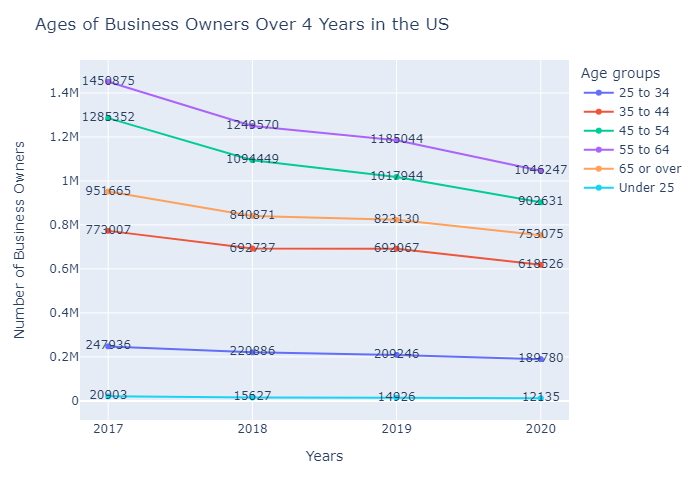

In [11]:
cols = [x for x in newdf.columns]
print(cols)

fig = px.line(newdf, x=newdf.index, y=cols,markers=True,text='value')

fig.update_layout(title='Ages of Business Owners Over 4 Years in the US',
                   xaxis_title='Years',
                   yaxis_title='Number of Business Owners',
                   legend_title="Age groups")

fig.show("png")


-   Line graph with Matplotlib

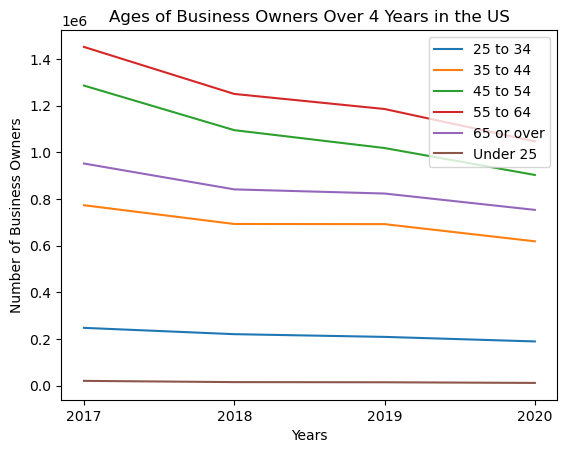

In [10]:

plt.plot(newdf.index,newdf[cols])
plt.legend(cols,loc='upper right')
plt.xlabel("Years")
plt.ylabel("Number of Business Owners")
plt.title("Ages of Business Owners Over 4 Years in the US")


plt.show()


